![logo](https://www.databolt.tech/images/logo.png)
Accelerate data science [www.databolt.tech](https://www.databolt.tech) | [github.com/d6t/d6t-python](https://github.com/d6t/d6t-python)


# DATA SCIENCE PROJECT TEMPLATES

## Regression
### UCI heart disease data

[Description](https://archive.ics.uci.edu/ml/datasets/heart+disease)

In [59]:
# processing
import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
import lightgbm
#lightgbm.LGBMRegressor
import shap
#shap.initjs()

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)


## preprocessing

In [60]:
%%capture

import d6tflow.pipes

d6tflow.pipes.init('intro-stat-learning',profile='default', reset=True) #, local_pipe=True

In [61]:
pipe = d6tflow.pipes.get_pipe()
pipe.pull()
print('where files are stored:',pipe.dirpath)

pulling: 0.00MB


0it [00:00, ?it/s]

where files are stored: d:\d6tpipe-files\files\default\intro-stat-learning


In [62]:
# tasks

class TaskProcessRawData(d6tflow.tasks.TaskPqPandas):

    def run(self):        
        df = pd.read_csv(pipe.dirpath/'Heart.csv',index_col=0)
        self.save(df)

@d6tflow.requires(TaskProcessRawData)
class TaskFeatures(d6tflow.tasks.TaskPqPandas):
    factorize = luigi.BoolParameter(default=True)
    
    def run(self):
        df = self.inputLoad()
        if self.factorize:
            for col in ['ChestPain','Thal']:
                df[col]=df[col].factorize()[0]
            df['AHD']=df['AHD'].map({'No':0,'Yes':1})
        df['target']=df['AHD']
        df = df.dropna()
        self.save(df)

In [63]:
d6tflow.run([TaskFeatures()],forced_all=True,confirm=False, forced_all_upstream=True)
df_train = TaskFeatures().outputLoad()

INFO: Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO: Informed scheduler that task   TaskProcessRawData__99914b932b   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   TaskProcessRawData__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 1 processes
INFO:luigi-interface:Running Worker with 1 processes
INFO: [pid 27500] Worker Worker(salt=845796482, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=27500) running   TaskProcessRawData()
INFO:luigi-interface:[pid 27500] Worker Worker(salt=845796482, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=27500) running   TaskProcessRawData()
INFO: [pid 27500] Worker Worker(salt=845796482, workers=1, host=DESKTOP-4OCFNJU, username=deepmind, pid=27500) done      TaskProcessRawData()
INFO:lu

In [64]:
df_train = TaskFeatures().outputLoad()

In [65]:
cfg_col_X_cat = ['Sex', 'Fbs', 'ExAng', 'RestECG', 'Slope', 'ChestPain', 'Thal', 'Ca']
cfg_col_X_num = ['Oldpeak', 'Age', 'RestBP', 'MaxHR', 'Chol']
cfg_col_X = cfg_col_X_cat+cfg_col_X_num
cfg_col_Y = 'target'

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

## data overview

In [67]:
print(df_train.columns)

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'AHD', 'target'],
      dtype='object')


In [68]:
df_train.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD,target
1,63,1,0,145,233,1,2,150,0,2.3,3,0.0,0,0,0
2,67,1,1,160,286,0,2,108,1,1.5,2,3.0,1,1,1
3,67,1,1,120,229,0,2,129,1,2.6,2,2.0,2,1,1
4,37,1,2,130,250,0,0,187,0,3.5,3,0.0,1,0,0
5,41,0,3,130,204,0,2,172,0,1.4,1,0.0,1,0,0


In [69]:
print('observations and type')
df_train.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 1 to 302
Data columns (total 15 columns):
Age          299 non-null int64
Sex          299 non-null int64
ChestPain    299 non-null int64
RestBP       299 non-null int64
Chol         299 non-null int64
Fbs          299 non-null int64
RestECG      299 non-null int64
MaxHR        299 non-null int64
ExAng        299 non-null int64
Oldpeak      299 non-null float64
Slope        299 non-null int64
Ca           299 non-null float64
Thal         299 non-null int64
AHD          299 non-null int64
target       299 non-null int64
dtypes: float64(2), int64(13)
memory usage: 37.4 KB


In [70]:
print('missing values')
df_train.apply(lambda x: x.isna().sum()/len(x))

missing values


Age          0.0
Sex          0.0
ChestPain    0.0
RestBP       0.0
Chol         0.0
Fbs          0.0
RestECG      0.0
MaxHR        0.0
ExAng        0.0
Oldpeak      0.0
Slope        0.0
Ca           0.0
Thal         0.0
AHD          0.0
target       0.0
dtype: float64

In [71]:
print('unique values')
df_train.apply(lambda x: len(x.unique()))

unique values


Age           41
Sex            2
ChestPain      4
RestBP        50
Chol         152
Fbs            2
RestECG        3
MaxHR         91
ExAng          2
Oldpeak       40
Slope          3
Ca             4
Thal           4
AHD            2
target         2
dtype: int64

In [72]:
df_train.describe().round(2)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD,target
count,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00,299.00
mean,54.53,0.68,1.53,131.67,247.10,0.15,1.00,149.51,0.33,1.05,1.60,0.67,1.31,0.46,0.46
std,9.02,0.47,0.86,17.71,51.91,0.35,0.99,22.95,0.47,1.16,0.62,0.94,0.61,0.50,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,-1.00,0.00,0.00
25%,48.00,0.00,1.00,120.00,211.00,0.00,0.00,133.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
50%,56.00,1.00,1.00,130.00,242.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,1.00,0.00,0.00
75%,61.00,1.00,2.00,140.00,275.50,0.00,2.00,165.50,1.00,1.60,2.00,1.00,2.00,1.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,2.00,1.00,1.00


### distribution of target variable

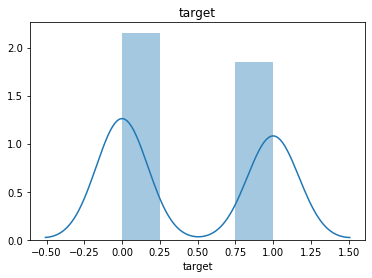

In [73]:
sns.distplot(df_train[cfg_col_Y]).set_title(cfg_col_Y);

### distribution of input variables

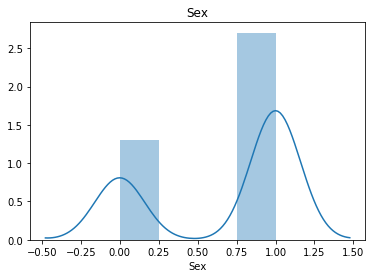

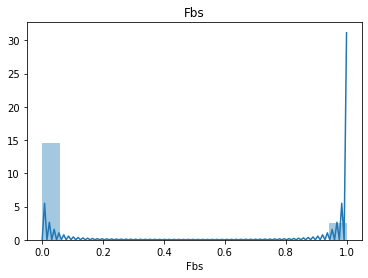

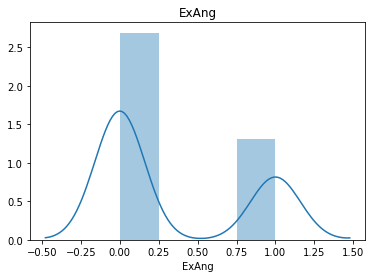

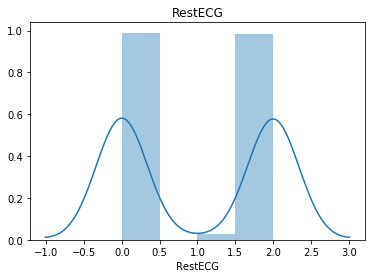

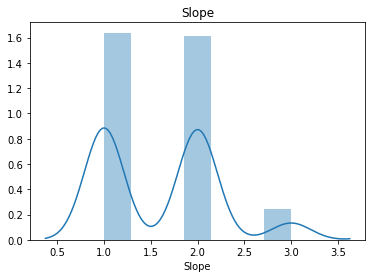

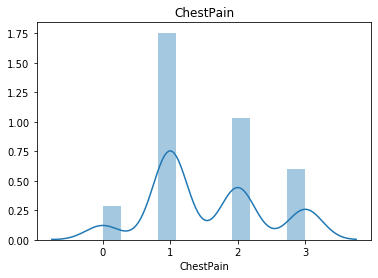

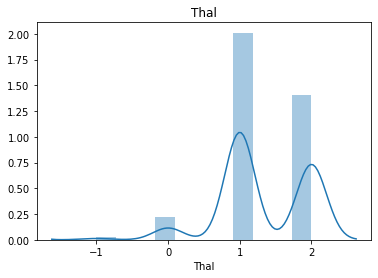

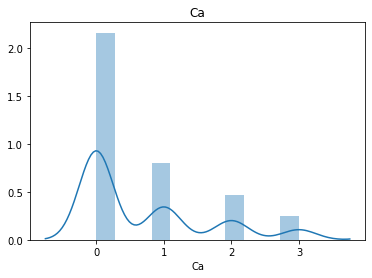

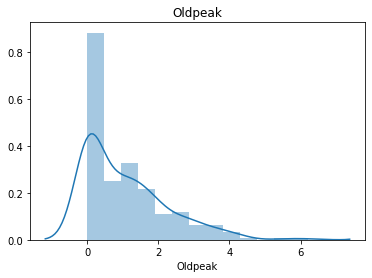

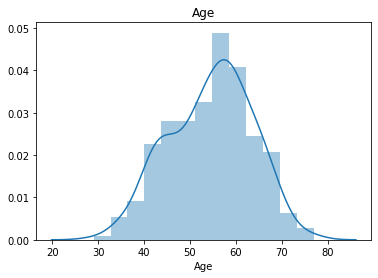

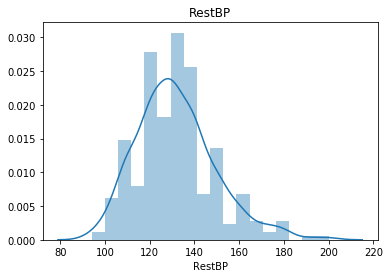

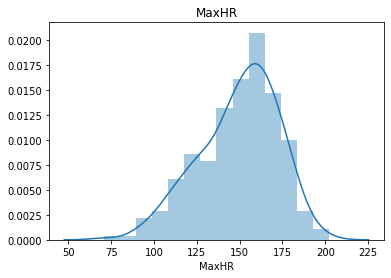

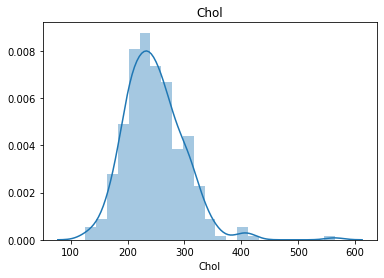

In [74]:
for icol in cfg_col_X:
    plt.figure();
    sns.distplot(df_train[icol]).set_title(icol);


### relation of inut variables to target variable

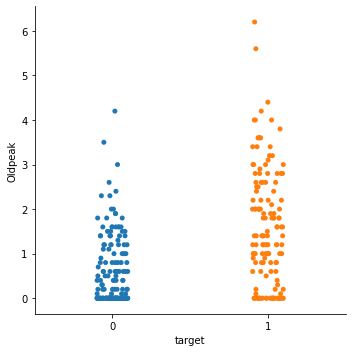

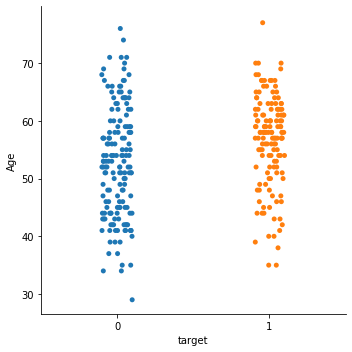

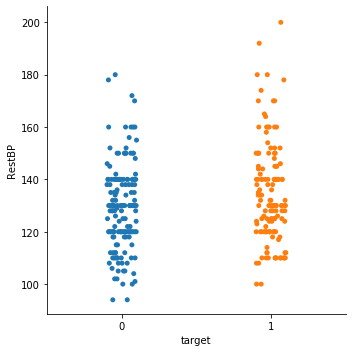

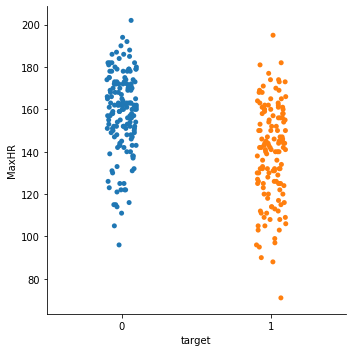

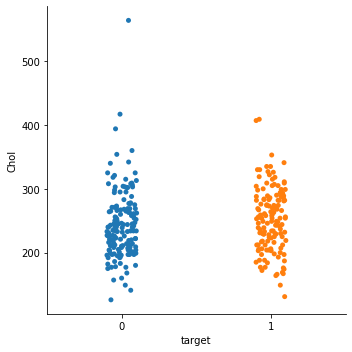

In [75]:
for icol in cfg_col_X_num:
    sns.catplot(x="target", y=icol, data=df_train)

In [76]:
for icol in cfg_col_X_cat:
    print(f'\n{icol}')
    print(df_train.groupby(icol)['target'].agg(['mean','count']))



Sex
         mean  count
Sex                 
0    0.257732     97
1    0.559406    202

Fbs
         mean  count
Fbs                 
0    0.458824    255
1    0.477273     44

ExAng
           mean  count
ExAng                 
0      0.313433    201
1      0.765306     98

RestECG
             mean  count
RestECG                 
0        0.378378    148
1        0.750000      4
2        0.537415    147

Slope
           mean  count
Slope                 
1      0.257143    140
2      0.652174    138
3      0.571429     21

ChestPain
               mean  count
ChestPain                 
0          0.304348     23
1          0.727273    143
2          0.214286     84
3          0.183673     49

Thal
          mean  count
Thal                 
-1    0.500000      2
 0    0.666667     18
 1    0.225610    164
 2    0.765217    115

Ca
         mean  count
Ca                  
0.0  0.261364    176
1.0  0.676923     65
2.0  0.815789     38
3.0  0.850000     20


## model training

In [77]:
df_trainX, df_trainY = df_train[cfg_col_X], df_train[cfg_col_Y]

In [78]:
df_train['target_naive1']=df_train['target'].value_counts().nlargest(n=1).index[0] # most common class

In [79]:
mod_ols = sm.Logit(df_trainY,sm.add_constant(df_trainX))

res_ols = mod_ols.fit()
print(res_ols.summary())
df_train['target_ols_p']=res_ols.predict()

Optimization terminated successfully.
         Current function value: 0.373537
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  299
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           13
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                  0.4588
Time:                        23:09:42   Log-Likelihood:                -111.69
converged:                       True   LL-Null:                       -206.37
Covariance Type:            nonrobust   LLR p-value:                 2.078e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3611      2.570     -1.308      0.191      -8.398       1.676
Sex            1.5189      0.

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


In [80]:
mod_skols = LogisticRegression()
mod_skols.fit(df_trainX,df_trainY)
df_train['target_skols']=mod_skols.predict(df_trainX)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


In [81]:
mod_lgbm = lightgbm.LGBMClassifier(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df_trainX,df_trainY)
df_train['target_lgbm']=mod_lgbm.predict(df_trainX)
df_train['target_lgbm_p']=mod_lgbm.predict_proba(df_trainX)[:,1]

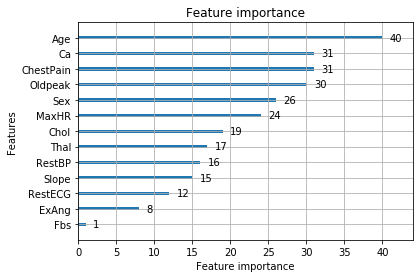

In [82]:
lightgbm.plot_importance(mod_lgbm)

## model evaluation

### prediction errors: in-sample

In [83]:
print('naive class',roc_auc_score(df_train[cfg_col_Y],df_train['target_naive1']))
print('ols',roc_auc_score(df_train[cfg_col_Y],df_train['target_skols']))
print('gbm',roc_auc_score(df_train[cfg_col_Y],df_train['target_lgbm']))

naive class 0.5
ols 0.8390269151138716
gbm 0.8938923395445134


### prediction errors: cross-validation

In [84]:
print('ols',cross_validate(mod_skols, df_trainX, df_trainY, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())
print('gbm',cross_validate(mod_lgbm, df_trainX, df_trainY, return_train_score=False, scoring='roc_auc', cv=10)['test_score'].mean())

ols 0.8910209276018101


Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


gbm 0.908962912087912


### Classification quality

In [85]:
cfg_thresh = 0.5
print(classification_report((res_ols.predict()>cfg_thresh).astype(int), df_train['target']))

# print(pd.crosstab((res_ols.predict()>cfg_thresh).astype(int),df_train['target']))
# print(classification_report(df_train['target'], (res_ols.predict()>cfg_thresh).astype(int)))


              precision    recall  f1-score   support

           0       0.88      0.85      0.86       168
           1       0.81      0.85      0.83       131

    accuracy                           0.85       299
   macro avg       0.85      0.85      0.85       299
weighted avg       0.85      0.85      0.85       299



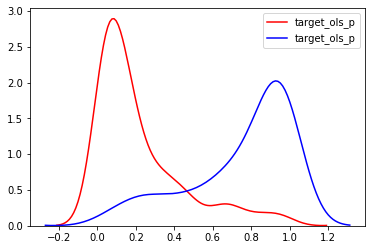

In [86]:
sns.kdeplot(df_train.loc[df_train['target']==0, 'target_ols_p'], color="r")
sns.kdeplot(df_train.loc[df_train['target']==1, 'target_ols_p'], color="b")

In [87]:
print(classification_report(mod_lgbm.predict(df_trainX), df_train['target']))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       168
           1       0.86      0.91      0.88       131

    accuracy                           0.90       299
   macro avg       0.89      0.90      0.90       299
weighted avg       0.90      0.90      0.90       299



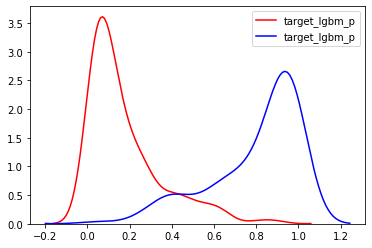

In [88]:
sns.kdeplot(df_train.loc[df_train['target']==0, 'target_lgbm_p'], color="r")
sns.kdeplot(df_train.loc[df_train['target']==1, 'target_lgbm_p'], color="b")

## model interpretation

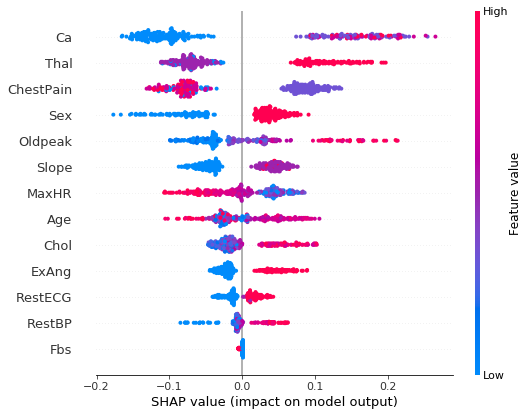

In [89]:
explainer = shap.TreeExplainer(mod_lgbm, df_trainX,model_output="probability")
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)


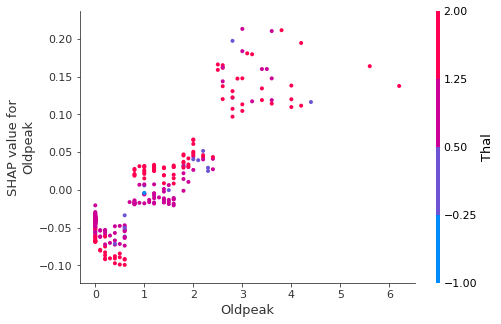

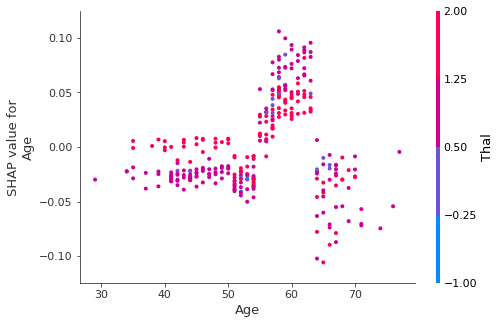

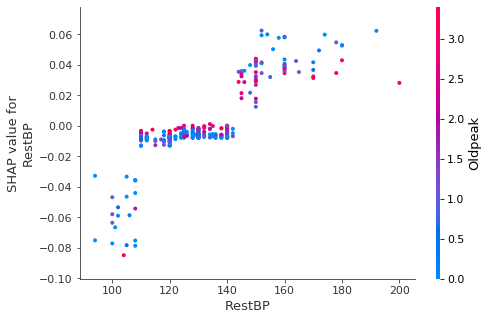

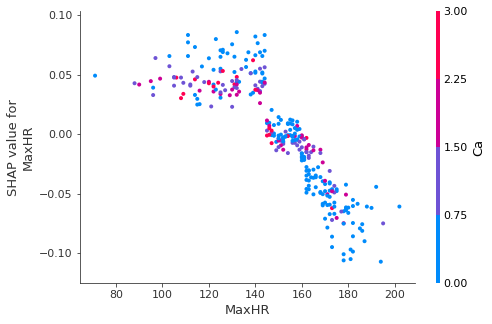

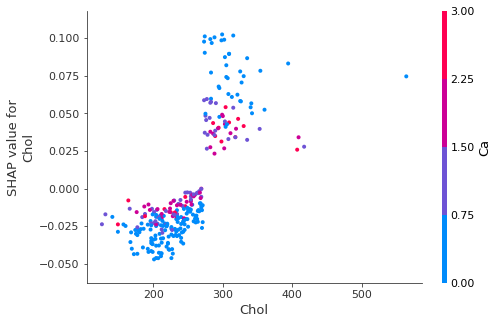

In [90]:
for col in cfg_col_X_num:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)

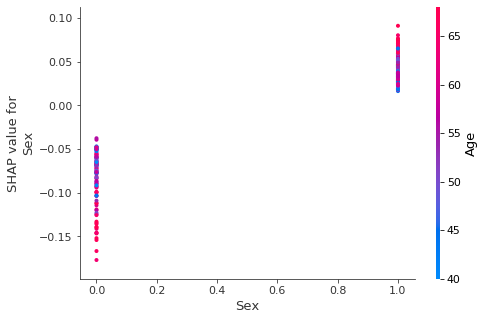

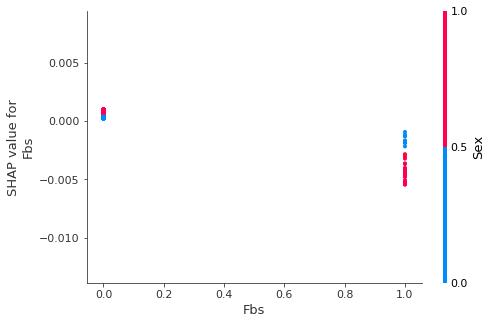

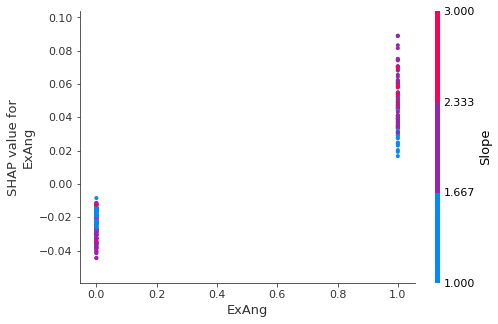

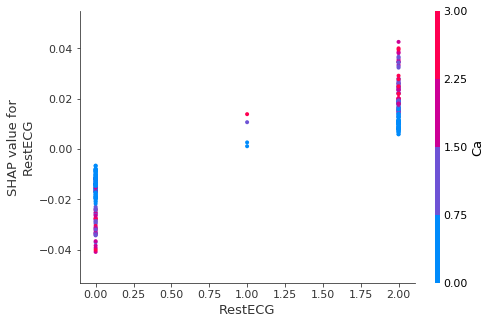

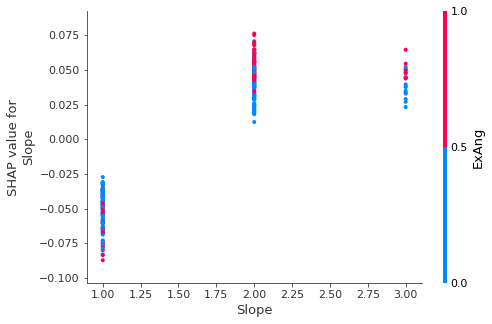

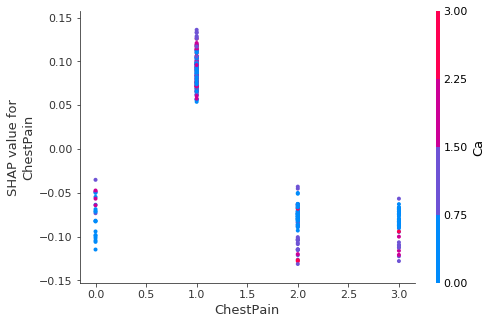

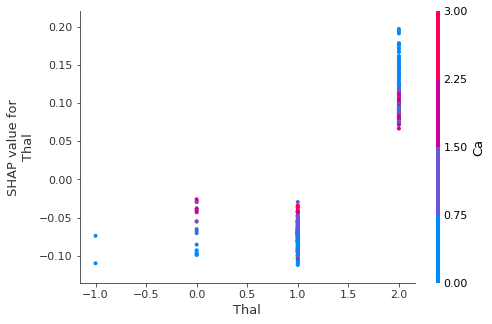

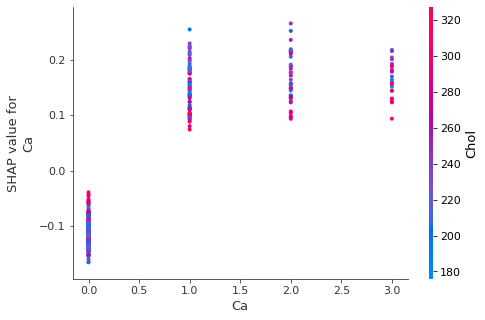

In [91]:
for col in cfg_col_X_cat:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)

In [92]:
dict(zip(cfg_col_X,range(len(cfg_col_X))))

{'Sex': 0,
 'Fbs': 1,
 'ExAng': 2,
 'RestECG': 3,
 'Slope': 4,
 'ChestPain': 5,
 'Thal': 6,
 'Ca': 7,
 'Oldpeak': 8,
 'Age': 9,
 'RestBP': 10,
 'MaxHR': 11,
 'Chol': 12}

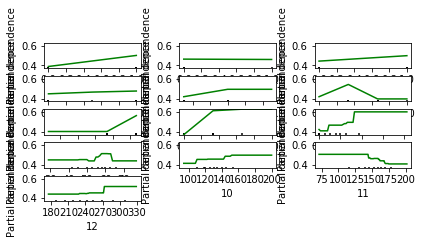

In [93]:
plot_partial_dependence(mod_lgbm, df_trainX, range(len(cfg_col_X))) 